# MLP Predictor for stock data

## Author: Danilo Filippo Reiszel Pereira
Univesidade Federal do Rio de Janeiro

This notebook contains the creation a Multi-layer Perceptron model to predict D+1 closing prices of PETR4 stocks, using as input 10 delays of its return series

In [2]:
from __future__ import print_function
import sys, os
sys.path.append('../../../../src')
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralstocks.dataacquisition import *
from neuralstocks.plots import *
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


# Global Params
Setting global params and useful variables, such as directories and image styling

In [3]:
pathPETR4 = '../../../../../data/stocks/PETR4/diario/PETR4.CSV'
pathIBOV = '../../../../../data/indexes/IBOV/diario/IBOV.CSV'
pathUSDBRL = '../../../../../data/forex/USDBRL/diario/USDBRL.CSV'

decomposeModel = 'additive'

saveVarDir = './Variables'
os.makedirs(saveVarDir) if not os.path.exists(saveVarDir) else print('')

saveFigDir = './Figures'
os.makedirs(saveFigDir) if not os.path.exists(saveFigDir) else print('')

saveModelDir = './Models'
os.makedirs(saveModelDir) if not os.path.exists(saveModelDir) else print('')

saveImgFormat = 'png'

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

## Data Acquisition and Preprocessing

Gathers and preprocess data. Data from auxiliary time series (such as IBOV index and USDBRL exchange rate) is also gathered, though tipically less indicators are calculated for this series. Trend Extraction is applied to desired series.

<strong>List of indicators applied to main time series: </strong>
<ul>
    <li>Mean and Standard Deviation, 20 periods</li>
    <li>Returns Calculations:
        <ul>
            <li>Close<sub>d</sub> / Close<sub>d-1</sub></li>
            <li>Close<sub>d</sub> / Open<sub>d</sub></li>
            <li>High<sub>d</sub> / Close<sub>d</sub></li>
            <li>Low<sub>d</sub> / Close<sub>d</sub></li>
        </ul>
    </li>
    <li>EMAs:
        <ul>
            <li>Close, 17 periods</li>
            <li>Close, 72 periods</li>
            <li>Close, 200 periods</li>
            <li>Volume, 21 periods</li>
        </ul>
    </li>
    <li>MACD, fast EMA = 12 periods, slow EMA = 26 periods, signal EMA = 9 periods</li>
    <li>Bollinger Bands, 20 periods</li>
    <li>On-Balance Volume (OBV)</li>
</ul>

In [4]:
init_time = time.time()
PETR4 = acquireData(filePath = pathPETR4,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], ['Close', 'Open'], ['High', 'Close' ], ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}, 
                                 {'column': 'Volume', 'lenght': 21}],
                    MACDParams = [{'fast_lenght': 12, 'slow_lenght': 26, 'signal_lenght': 9}],
                    BBParams = [{'lenght': 20}],
                    OBVParams = [{'lenght': None}],
                    colPrefix = 'PETR4',
                    dropNan = True
                   )

IBOV = acquireData(filePath = pathIBOV,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], ['Close', 'Open'], ['High', 'Close' ], ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}],
                    colPrefix = 'IBOV',
                    dropNan = True
                  )

USDBRL= acquireData(filePath = pathUSDBRL,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], ['Close', 'Open'], ['High', 'Close' ], ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}],
                    colPrefix = 'USDBRL',
                    dropNan = True
                   )


end_time = time.time()
print('Time to acquire and process data: '+str(end_time-init_time)+' seconds')

Time to acquire and process data: 4.1020629406 seconds


## Dataset concatenation and selection of wich features to feed to the model

In [5]:
df = pd.concat([PETR4, IBOV, USDBRL], axis = 1).dropna()

columnsToUse = [ 
                'PETR4_Close_rollStd20', 
                'PETR4_Close_returns', 'PETR4_Close/Open_returns', 'PETR4_High/Close_returns', 'PETR4_Low/Close_returns', 
                'PETR4_Close_EMA17_logdiff', 'PETR4_Close_EMA72_logdiff', 'PETR4_Close_EMA200_logdiff', 'PETR4_Volume_EMA21_logdiff', 
                'PETR4_MACD_12_26_9', 'PETR4_MACDsignal_12_26_9', 'PETR4_Bollinger%b_20', 'PETR4_OBV', 
                'PETR4_Holiday',
                'IBOV_Close_rollStd20', 
                'IBOV_Close_returns', 'IBOV_Close/Open_returns', 'IBOV_High/Close_returns', 'IBOV_Low/Close_returns',
                'IBOV_Close_EMA17_logdiff', 'IBOV_Close_EMA72_logdiff', 'IBOV_Close_EMA200_logdiff',
                'USDBRL_Close_rollStd20', 
                'USDBRL_Close_returns', 'USDBRL_Close/Open_returns', 'USDBRL_High/Close_returns', 'USDBRL_Low/Close_returns',
                'USDBRL_Close_EMA17_logdiff', 'USDBRL_Close_EMA72_logdiff', 'USDBRL_Close_EMA200_logdiff',
               ]

## Creation of feature matrix and output array, split of data in Train, Validation and Test sets
All data from 2017 is used as Test set, reamining data is split into train and validation according to *validationSplitSize*

In [12]:
xTrain, yTrain, xVal, yVal, xTest, yTest = prepData(df = df, 
                                                    columnsToUse = columnsToUse, 
                                                    columnToPredict = 'PETR4_Close_returns', 
                                                    nDelays = 10, 
                                                    testSetSize = len(df['2017']), 
                                                    validationSplitSize = 0.15)

print('Number of train batches: {}'.format(len(xTrain)))
print('Number of validation batches: {}'.format(len(xVal)))
print('Number of test batches: {}'.format(len(xTest)))
print('Number of inputs per batch: {}'.format(len(xTrain[0])))

Number of train batches: 3557
Number of validation batches: 628
Number of test batches: 175
Number of inputs per batch: 39


## Feature Scalling

Technique used: Normalisation

In [13]:
xScaler = MinMaxScaler(feature_range = (-1,1))
xScaler.fit(np.append(xTrain, xVal, axis = 0))

yScaler = MinMaxScaler(feature_range = (-1,1))
yScaler.fit(np.append(yTrain, yVal, axis = 0))

xTrain = xScaler.transform(xTrain)
xVal = xScaler.transform(xVal)
xTest  = xScaler.transform(xTest)

yTrain = yScaler.transform(yTrain)
yVal = yScaler.transform(yVal)

## Creation and initializaion of a MLP

In [22]:
inputDim = xTrain.shape[1]

MLP = Sequential([Dense(5, activation = 'tanh', input_dim = inputDim),
                  Dense(1, activation = 'tanh')])

SGD = optimizers.SGD(lr=0.01, momentum=0.00, decay=0.0, nesterov=False)

MLP.compile(optimizer=SGD, loss='mse')
MLP.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 5)                 200       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6         
Total params: 206
Trainable params: 206
Non-trainable params: 0
_________________________________________________________________


## Fitting the Neural Network to the data

In [23]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, mode='auto')

init_time = time.time()

fitHistory = MLP.fit(xTrain, 
                     yTrain, 
                     epochs = 2000,
                     verbose = 1,
                     shuffle = True,
                     validation_data = (xVal, yVal), 
                     callbacks = [earlyStopping])

end_time = time.time()

print('Time to fit model: '+str(end_time-init_time)+' seconds')

Train on 3557 samples, validate on 628 samples
Epoch 1/2000
3557/3557 [==============================] - 0s - loss: 0.1112 - val_loss: 0.0658
Epoch 2/2000
3557/3557 [==============================] - 0s - loss: 0.0675 - val_loss: 0.0470
Epoch 3/2000
3557/3557 [==============================] - 0s - loss: 0.0546 - val_loss: 0.0404
Epoch 4/2000
3557/3557 [==============================] - 0s - loss: 0.0484 - val_loss: 0.0361
Epoch 5/2000
3557/3557 [==============================] - 0s - loss: 0.0446 - val_loss: 0.0347
Epoch 6/2000
3557/3557 [==============================] - 0s - loss: 0.0421 - val_loss: 0.0318
Epoch 7/2000
3557/3557 [==============================] - 0s - loss: 0.0403 - val_loss: 0.0303
Epoch 8/2000
3557/3557 [==============================] - 0s - loss: 0.0390 - val_loss: 0.0295
Epoch 9/2000
3557/3557 [==============================] - 0s - loss: 0.0379 - val_loss: 0.0289
Epoch 10/2000
3557/3557 [==============================] - 0s - loss: 0.0371 - val_loss: 0.0287
Ep

3557/3557 [==============================] - 0s - loss: 0.0303 - val_loss: 0.0236
Epoch 86/2000
3557/3557 [==============================] - 0s - loss: 0.0303 - val_loss: 0.0235
Epoch 87/2000
3557/3557 [==============================] - 0s - loss: 0.0303 - val_loss: 0.0236
Epoch 88/2000
3557/3557 [==============================] - 0s - loss: 0.0303 - val_loss: 0.0235
Epoch 89/2000
3557/3557 [==============================] - 0s - loss: 0.0302 - val_loss: 0.0235
Epoch 90/2000
3557/3557 [==============================] - 0s - loss: 0.0302 - val_loss: 0.0237
Epoch 91/2000
3557/3557 [==============================] - 0s - loss: 0.0302 - val_loss: 0.0236
Epoch 92/2000
3557/3557 [==============================] - 0s - loss: 0.0302 - val_loss: 0.0235
Epoch 93/2000
3557/3557 [==============================] - 0s - loss: 0.0302 - val_loss: 0.0236
Epoch 94/2000
3557/3557 [==============================] - 0s - loss: 0.0302 - val_loss: 0.0237
Epoch 95/2000
3557/3557 [=============================

3557/3557 [==============================] - 0s - loss: 0.0298 - val_loss: 0.0233
Epoch 170/2000
3557/3557 [==============================] - 0s - loss: 0.0298 - val_loss: 0.0234
Epoch 171/2000
3557/3557 [==============================] - 0s - loss: 0.0298 - val_loss: 0.0233
Epoch 172/2000
3557/3557 [==============================] - 0s - loss: 0.0298 - val_loss: 0.0237
Epoch 173/2000
3557/3557 [==============================] - 0s - loss: 0.0298 - val_loss: 0.0233
Epoch 174/2000
3557/3557 [==============================] - 0s - loss: 0.0298 - val_loss: 0.0232
Epoch 175/2000
3557/3557 [==============================] - 0s - loss: 0.0298 - val_loss: 0.0233
Epoch 176/2000
3557/3557 [==============================] - 0s - loss: 0.0298 - val_loss: 0.0233
Epoch 177/2000
3557/3557 [==============================] - 0s - loss: 0.0298 - val_loss: 0.0233
Epoch 178/2000
3557/3557 [==============================] - 0s - loss: 0.0298 - val_loss: 0.0233
Epoch 179/2000
3557/3557 [===================

## Plot of RMSE per epoch, for Training Set and Validation Set


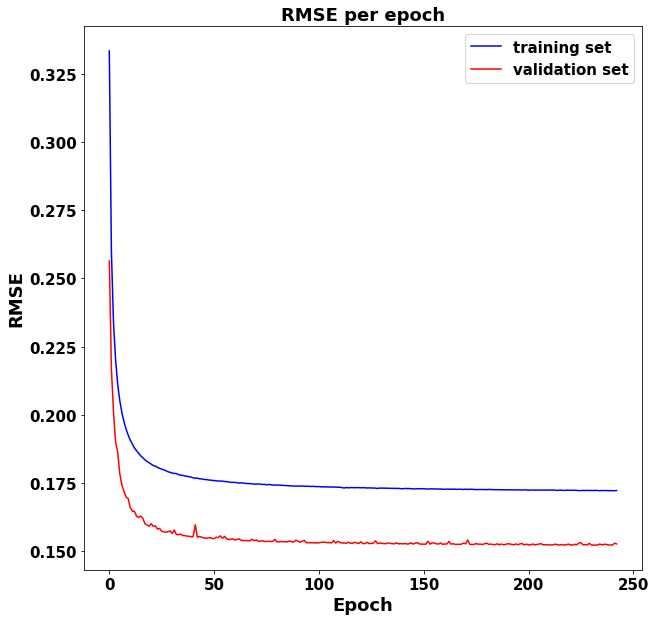

In [24]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(fitHistory.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(fitHistory.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
#fig.savefig('{}/{}.{}'.format(saveFigDir, 'RMSE_per_epoch_autoencoder_30_40', 'pdf'), bbox_inches='tight')

## Reconstruction of the time series using predicted values

(<matplotlib.figure.Figure at 0x8e17950>,
 <matplotlib.axes._subplots.AxesSubplot at 0x8f50210>)

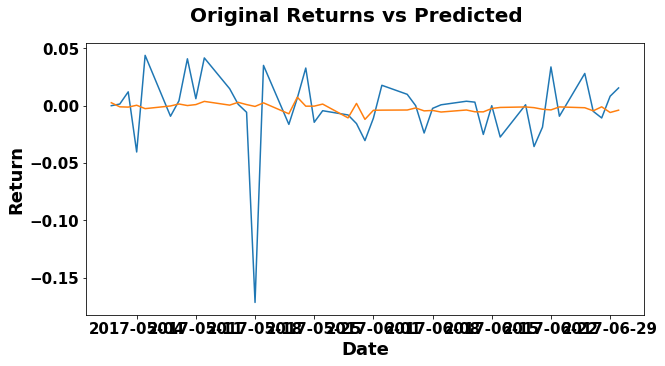

In [28]:
predictions = MLP.predict(xTest)
predictions = yScaler.inverse_transform(predictions)
predictions_clean = []
for p in predictions:
    predictions_clean.extend(p)
predictionsSeries = pd.Series(predictions_clean, index = df['2017'].index)

plotSeries([df['PETR4_Close_returns'], predictionsSeries],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Original Returns vs Predicted', ylabel = 'Return')